## **Load the Preprocessed Data**

First, you need to import the required libraries and load the `preprocessed_data.csv` file that you saved earlier.

In [1]:
import pandas as pd
import numpy as np

# Load the preprocessed data
new_data = pd.read_csv(r"E:/Random Python Scripts/CICIDS/CICIDS2017/preprocessed_data.csv")

## **Creating a balanced dataset for Multi-Class Classification**

The following dataset is highly imbalanced, we took the help of **SMOTE (Synthetic Minority Over-sampling Technique)** to upsample the minority classes while creating a balanced dataset for multi-class classification. This helped us in creating an overall balanced dataset to feed the classification models.

In [2]:
new_data['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

Ensures a more balanced dataset by controlling the number of samples per class.

In [3]:
class_counts = new_data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = new_data[new_data['Attack Type'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Type'] == name]
  if len(df) > 2500:
    df = df.sample(n = 5000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Type'].value_counts()

Attack Type
BENIGN         5000
DoS            5000
DDoS           5000
Port Scan      5000
Brute Force    5000
Web Attack     2143
Bot            1953
Name: count, dtype: int64

Combines the upsampled features and labels into a new DataFrame (`blnc_data`).

In [4]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Type'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Type'].value_counts()

Attack Type
Web Attack     5000
Brute Force    5000
DDoS           5000
DoS            5000
Port Scan      5000
BENIGN         5000
Bot            5000
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

features = blnc_data.drop('Attack Type', axis = 1)
labels = blnc_data['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

## **Random Forest Classifier**

**Parameters:**

`n_estimators`: This parameter specifies the number of decision trees to fit in the random forest.

`max_depth`: This parameter specifies the maximum depth of each decision tree in the random forest.

`max_features`: This parameter specifies the number of features to consider when looking for the best split in each tree.

`random_state`: This is to ensure that the output is deterministic and can be reproduced.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 15, max_depth = 8, max_features = 20, random_state = 0)
rf.fit(X_train, y_train)

cv_rf = cross_val_score(rf, X_train, y_train, cv = 5)
print('Random Forest Model')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf)))
print(f'\nMean cross-validation score: {cv_rf.mean():.2f}')

Random Forest Model

Cross-validation scores: 0.9851428571428571, 0.9830476190476191, 0.9868571428571429, 0.9838095238095238, 0.9838095238095238

Mean cross-validation score: 0.98


In [9]:
# Make predictions on the test set
y_pred_rf = rf.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred_rf)
print(report)

              precision    recall  f1-score   support

      BENIGN       0.98      0.96      0.97      1247
         Bot       0.98      1.00      0.99      1233
 Brute Force       1.00      0.97      0.98      1245
        DDoS       0.98      1.00      0.99      1245
         DoS       0.99      0.98      0.98      1299
   Port Scan       1.00      1.00      1.00      1238
  Web Attack       0.97      0.99      0.98      1243

    accuracy                           0.98      8750
   macro avg       0.98      0.98      0.98      8750
weighted avg       0.98      0.98      0.98      8750



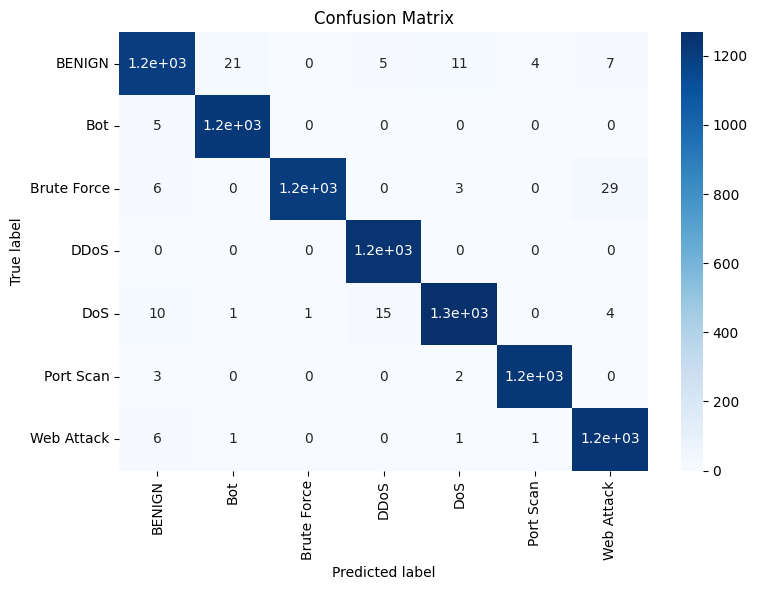

In [10]:
# Predicting using the first random forest model
y_pred_rf = rf.predict(X_test)

# Generating the confusion matrix for model 1
conf_matrix_model = confusion_matrix(y_test, y_pred_rf)

# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_model, annot=True, cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save the Random Forest model to a file using joblib
rf_model_filename = 'random_forest_model.joblib'
joblib.dump(rf, rf_model_filename)

print(f'Random Forest model saved to {rf_model_filename}')

In [ ]:
'''
# Load the Random Forest model from the file
loaded_rf = joblib.load(rf_model_filename)

# Example of making predictions
predictions = loaded_rf.predict(X_test)
print(predictions)
'''

## **Decision Tree Classifier**

**Parameters:**

`max_depth`: This parameter specifies the maximum depth of the tree.


In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 8)
dt.fit(X_train, y_train)

cv_dt = cross_val_score(dt, X_train, y_train, cv = 5)
print('Decision Tree Model')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt)))
print(f'\nMean cross-validation score: {cv_dt.mean():.2f}')

Decision Tree Model

Cross-validation scores: 0.9706666666666667, 0.9780952380952381, 0.9771428571428571, 0.9782857142857143, 0.9780952380952381

Mean cross-validation score: 0.98


In [12]:
# Make predictions on the test set
y_pred_dt = dt.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred_dt)
print(report)

              precision    recall  f1-score   support

      BENIGN       0.96      0.95      0.95      1247
         Bot       0.98      0.99      0.98      1233
 Brute Force       1.00      0.97      0.98      1245
        DDoS       0.98      1.00      0.99      1245
         DoS       0.98      0.97      0.98      1299
   Port Scan       1.00      1.00      1.00      1238
  Web Attack       0.96      0.99      0.97      1243

    accuracy                           0.98      8750
   macro avg       0.98      0.98      0.98      8750
weighted avg       0.98      0.98      0.98      8750



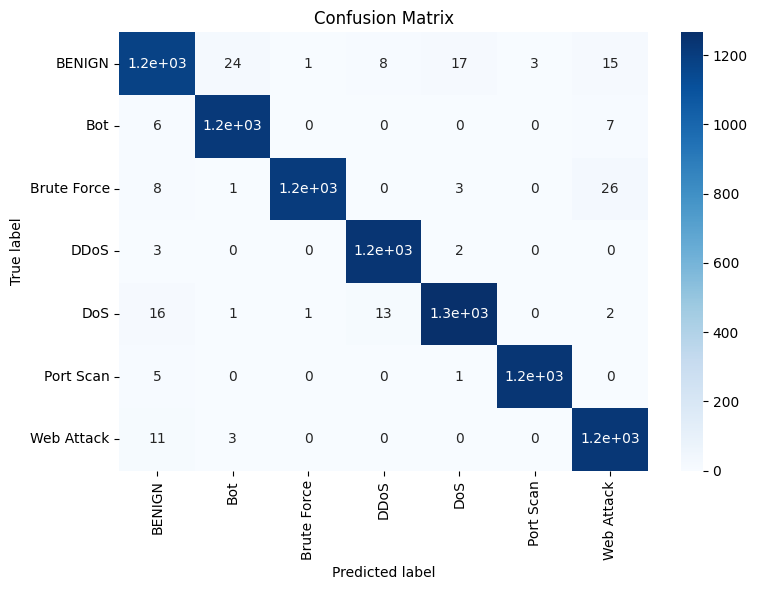

In [13]:
# Predicting using the first decision tree model
y_pred_dt = dt.predict(X_test)

# Generating the confusion matrix for model 1
conf_matrix_model = confusion_matrix(y_test, y_pred_dt)

# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_model, annot=True, cmap='Blues', xticklabels=dt.classes_, yticklabels=dt.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save the Decision Tree model to a file using joblib
dt_model_filename = 'decision_tree_model.joblib'
joblib.dump(dt, dt_model_filename)

print(f'Decision Tree model saved to {dt_model_filename}')

In [ ]:
'''
# Load the Decision Tree model from the file
loaded_dt = joblib.load(dt_model_filename)

# Example of making predictions
predictions = loaded_dt.predict(X_test)
print(predictions)
'''

## **K Nearest Neighbours**

**Parameters:**

`n_neighbors`: This is a hyperparameter of the KNN algorithm that specifies the number of neighbors to consider when making predictions for a new input data point. 

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train, y_train)

cv_knn = cross_val_score(knn, X_train, y_train, cv = 5)
print('K Nearest Neighbors Model')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn)))
print(f'\nMean cross-validation score: {cv_knn.mean():.2f}')

K Nearest Neighbors Model

Cross-validation scores: 0.9792380952380952, 0.9805714285714285, 0.9792380952380952, 0.979047619047619, 0.9771428571428571

Mean cross-validation score: 0.98


In [15]:
# Make predictions on the test set
y_pred_knn = knn.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred_knn)
print(report)

              precision    recall  f1-score   support

      BENIGN       0.98      0.93      0.95      1247
         Bot       0.98      1.00      0.99      1233
 Brute Force       0.98      0.99      0.98      1245
        DDoS       0.99      0.99      0.99      1245
         DoS       0.98      0.99      0.98      1299
   Port Scan       0.98      0.99      0.99      1238
  Web Attack       0.98      0.99      0.98      1243

    accuracy                           0.98      8750
   macro avg       0.98      0.98      0.98      8750
weighted avg       0.98      0.98      0.98      8750



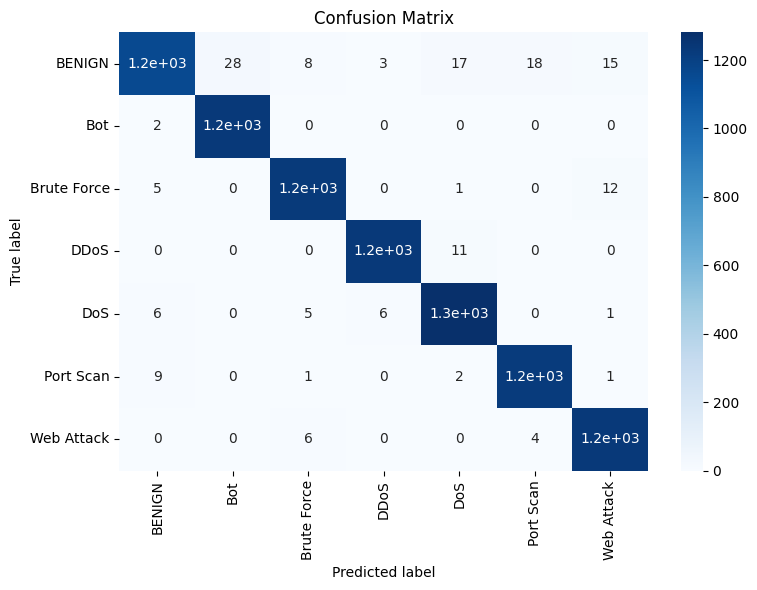

In [16]:
# Predicting using the first KNN model
y_pred_knn = knn.predict(X_test)

# Generating the confusion matrix for model 1
conf_matrix_model = confusion_matrix(y_test, y_pred_knn)

# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_model, annot=True, cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save the KNN model to a file using joblib
knn_model_filename = 'knn_model.joblib'
joblib.dump(knn, knn_model_filename)

print(f'K Nearest Neighbors model saved to {knn_model_filename}')

In [ ]:
'''
# Load the KNN model from the file
loaded_knn = joblib.load(knn_model_filename)

# Example of making predictions
predictions = loaded_knn.predict(X_test)
print(predictions)
'''

# **Performance Evaluation**

### Binary Classification Comparison Table ###
           Model    BENIGN       Bot  Brute Force      DDoS       DoS  \
0            KNN  0.981356  0.977760     0.983962  0.992759  0.976372   
1  Decision Tree  0.960098  0.976781     0.998346  0.983347  0.982157   
2  Random Forest  0.975590  0.981615     0.999172  0.984190  0.986770   

   Port Scan  Web Attack  Accuracy  
0   0.982358    0.977021  0.981600  
1   0.997571    0.960907  0.979771  
2   0.995961    0.968603  0.984457  


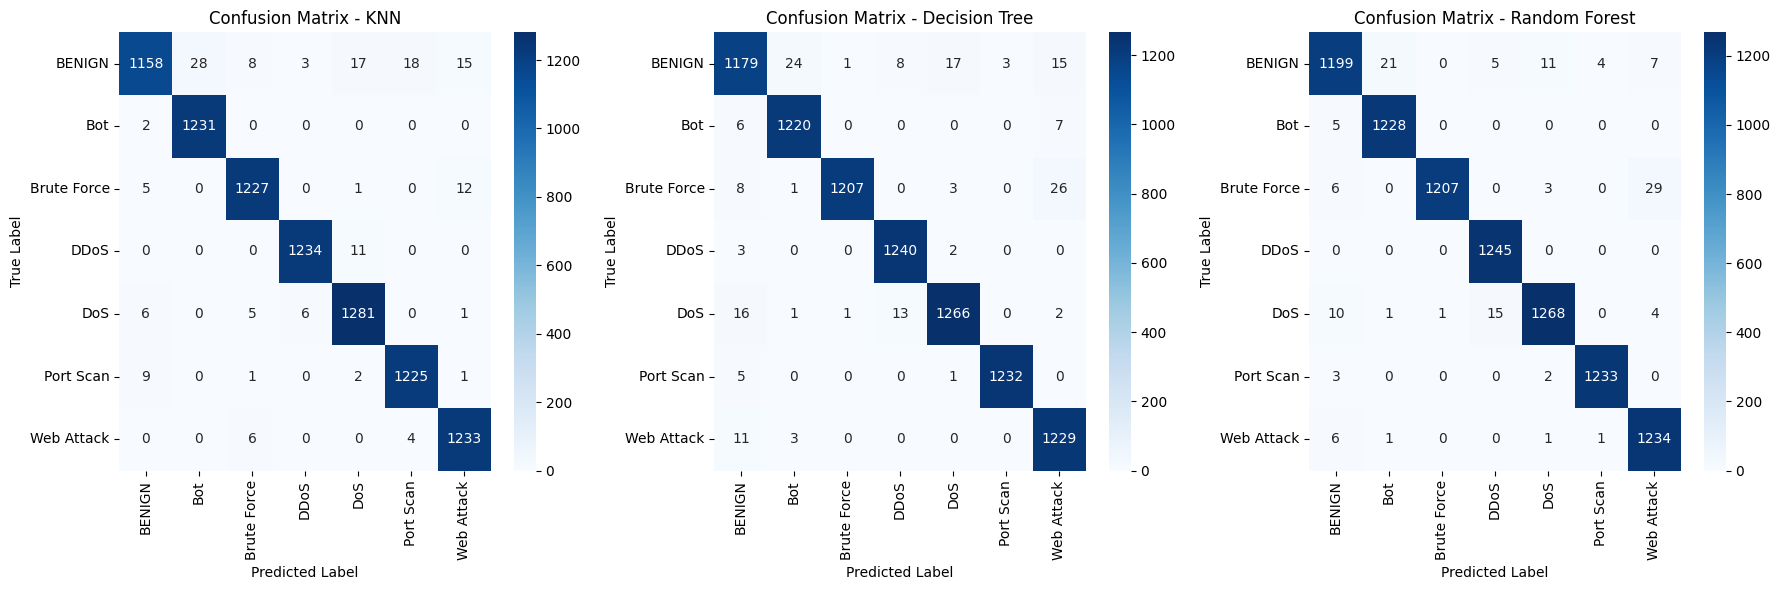

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set for KNN
y_pred_knn = knn.predict(X_test)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)

# Make predictions on the test set for Decision Tree
y_pred_dt = dt.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

# Make predictions on the test set for Random Forest
y_pred_rf = rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Extract relevant metrics for all models
class_labels = ['BENIGN', 'Bot', 'Brute Force', 'DDoS', 'DoS', 'Port Scan', 'Web Attack']

# Create a DataFrame to compare models
comparison_df = pd.DataFrame(columns=['Metric'] + class_labels + ['Accuracy'])

# Fill in metrics for each model
for model_name, report in zip(['KNN', 'Decision Tree', 'Random Forest'], [report_knn, report_dt, report_rf]):
    metrics = [report[label] for label in class_labels]  # Extract metrics for each class
    accuracies = report['accuracy']  # Overall accuracy
    comparison_df.loc[len(comparison_df)] = [model_name] + [metrics[i]['precision'] for i in range(len(class_labels))] + [accuracies]

# Rename the DataFrame columns appropriately
comparison_df.columns = ['Model'] + class_labels + ['Accuracy']

# Display the comparison table
print("### Binary Classification Comparison Table ###")
print(comparison_df)

# Plotting confusion matrices and heatmaps for each model
models = {'KNN': (y_pred_knn, knn), 'Decision Tree': (y_pred_dt, dt), 'Random Forest': (y_pred_rf, rf)}
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for ax, (model_name, (y_pred, model)) in zip(axs, models.items()):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_, ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()